# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
import pandas as pd
import numpy as np
import random
import pickle

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from matplotlib.colors import hsv_to_rgb
from matplotlib.colors import rgb_to_hsv

In [3]:
import os
import tensorflow as tf
import cv2
import time
from time import gmtime, strftime
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [4]:
# Load pickled data
training_file = "../traffic-signs-data/train.p"
validation_file = "../traffic-signs-data/valid.p"
testing_file = "../traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [5]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [6]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8),
 array([ 180, 1980, 2010, 1260, 1770, 1650,  360, 1290, 1260, 1320, 1800,
        1170, 1890, 1920,  690,  540,  360,  990, 1080,  180,  300,  270,
         330,  450,  240, 1350,  540,  210,  480,  240,  390,  690,  210,
         599,  360, 1080,  330,  180, 1860,  270,  300,  210,  210], dtype=int64))

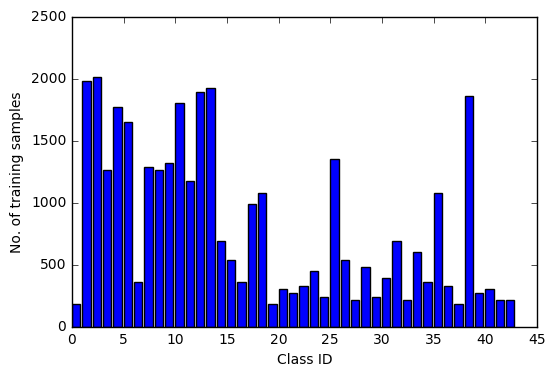

In [7]:
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])
plt.xlabel("Class ID")
plt.ylabel("No. of training samples")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
SEED = 12345

In [9]:
np.random.seed(SEED)

In [10]:
random.seed(SEED)

In [11]:
index = random.randint(0, len(X_train))

28


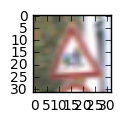

In [12]:
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
# plt.imshow(hsv_to_rgb(image))
print(y_train[index])

In [13]:
df_labels = pd.read_csv("signnames.csv", index_col=0)
df_labels.head()

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


#### Image Color Processing

In [14]:
def img_gradient(img, x=1, y=0, s_thresh=(100, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    sobel_img = cv2.Sobel(l_channel, cv2.CV_64F, x, y) # Take the derivative in x
    abs_sobel = np.absolute(sobel_img)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    return sbinary

In [15]:
# plt.imshow(img_gradient(image), cmap='gray')

In [16]:
def rgb_to_gray(rgb):
    x_shape = list(rgb.shape)
    x_shape[3] = 1
    gray = np.dot(rgb, [0.2989, 0.5870, 0.1140])
    return gray.reshape(x_shape)

def imgs_to_gray(X):
    x_shape = list(X.shape)
    x_shape[3] = 1
    return np.mean(X, axis=3).reshape(x_shape)

def rgb_to_hsv_n(imgs):
    return np.array([rgb_to_hsv(imgs[i].squeeze()) for i in range(len(imgs))])

In [17]:
def normalize_img(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))
    
def normalize_imgs(imgs):
    return np.array([normalize_img(imgs[i]) for i in range(len(imgs))])

In [18]:
if X_train.max() > 2:
#     X_train = imgs_to_gray(X_train)
#     X_valid = imgs_to_gray(X_valid)
#     X_test = imgs_to_gray(X_test)
#     X_train = (X_train - 128.)/128.
#     X_valid = (X_valid - 128.)(/128.
#     X_test = (X_test - 128.)/128.
    
    X_train = X_train/255.
    X_valid = X_valid/255.
    X_test = X_test/255.
    
    X_train = rgb_to_gray(X_train)
    X_valid = rgb_to_gray(X_valid)
    X_test = rgb_to_gray(X_test)
    
#     X_train = normalize_imgs(X_train)
#     X_valid = normalize_imgs(X_valid)
#     X_test = normalize_imgs(X_test)
    
#     X_train = rgb_to_hsv_n(X_train)
#     X_valid = rgb_to_hsv_n(X_valid)
#     X_test = rgb_to_hsv_n(X_test)

#     X_train = np.concatenate((rgb_to_gray(X_train), rgb_to_hsv_n(X_train)[:,:,:,:2]), axis=3)
#     X_valid = np.concatenate((rgb_to_gray(X_valid), rgb_to_hsv_n(X_valid)[:,:,:,:2]), axis=3)
#     X_test = np.concatenate((rgb_to_gray(X_test), rgb_to_hsv_n(X_test)[:,:,:,:2]), axis=3)
else:
    print("Already normalized")

#### Calculate class weights to balance classes

In [19]:
class_counts = np.unique(y_train, return_counts=True)[1]
class_weights = np.divide(np.sum(class_counts), class_counts)
class_weights = class_weights/np.min(class_weights)

In [20]:
class_weights_int = class_weights.astype(int)

#### Rotate, Warp, Scale Image

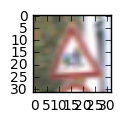

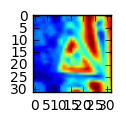

In [21]:
def get_perspective_matrix(src, dst):
    """
    Calculate and return perspective transform matrix M from 'src', 'dst' points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(img, M):
    """
    `img` is the undistored image
    `M` is the perspective transform matrix
    """
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), 
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REPLICATE)
    return warped
src = np.float32([
            [8, 8],
            [8, 24],
            [24, 24],
            [24, 8],
        ])

dst1 = np.float32([
            [8, 8],
            [7, 25],
            [24, 24],
            [25, 7],
        ])
dst2 = np.float32([
            [9, 9],
            [9, 23],
            [24, 24],
            [24, 8],
        ])
dst3 = np.float32([
            [8, 8],
            [9, 23],
            [25, 25],
            [24, 8],
        ])
dst4 = np.float32([
            [8, 8],
            [8, 24],
            [25, 25],
            [23, 9],
        ])
dst4 = np.float32([
            [7, 9],
            [8, 24],
            [24, 24],
            [23, 9],
        ])
M_list = [get_perspective_matrix(src, dst1)]
M_list.append(get_perspective_matrix(src, dst2))
M_list.append(get_perspective_matrix(src, dst3))
M_list.append(get_perspective_matrix(src, dst4))

# TEST IMAGE
plt.figure(figsize=(1,1))
plt.imshow(image)
image = X_train[index].squeeze()
plt.figure(figsize=(1,1))
plt.imshow(warp_perspective(image, M_list[2]))

TESTING IMAGE ROTATION, SCALING


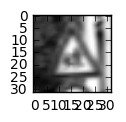

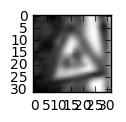

In [22]:
angle_list = [-5, 0, 5]
scale_list = [0.85, 1.1, 1.25]
invert_list = [0, 0]
warp_list = range(len(M_list)+1)
def rotate_image(image, angle, scale=1.0):
    (h, w) = image.shape[:2]
    center = (w/2, h/2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, 
                             borderMode=cv2.BORDER_REPLICATE)
    rotated = rotated.reshape(image.shape)
    return rotated

def invert_gray_image(image):
    return (1. - image)

def random_rotate_scale_image(image):
    angle = np.random.choice(angle_list, 1)[0]
    scale = np.random.choice(scale_list, 1)[0]
    
    rot_img = rotate_image(image=image, angle=angle, scale=scale)
#     if np.random.choice(invert_list, 1):
#         rot_img = invert_gray_image(rot_img)
    warp_sel = np.random.choice(warp_list, 1)[0]
    if warp_sel > 0:
        rot_img = warp_perspective(rot_img, M_list[warp_sel-1])
        rot_img = rot_img.reshape([rot_img.shape[0], rot_img.shape[1], 1])
    
    return rot_img

###### Test rotate scale image
# # img_rotate = rotate_image(X_train[index], angle=0, scale=1.1)
print("TESTING IMAGE ROTATION, SCALING")
img_rotate = random_rotate_scale_image(X_train[index])

plt.figure(figsize=(1,1))
plt.imshow(X_train[index].squeeze(), cmap='gray')

plt.figure(figsize=(1,1))
plt.imshow(img_rotate.squeeze(), cmap='gray')

In [23]:
np.random.choice(angle_list, 1)

array([-5])

In [24]:
np.random.choice(warp_list, 1)

array([1])

#### Generate synthetic data to balance class sizes

In [25]:
class_weights_int

array([11,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  1,  1,  2,  3,  5,
        2,  1, 11,  6,  7,  6,  4,  8,  1,  3,  9,  4,  8,  5,  2,  9,  3,
        5,  1,  6, 11,  1,  7,  6,  9,  9])

In [26]:
X_train_synth = X_train
y_train_synth = y_train

In [27]:
for class_i in np.where(class_weights_int > 0)[0]:
    class_i_ids = np.where(y_train==class_i)
    # calculate synth fraction per class to balance class samples. 
    # Below implementation should result in approx max imbalance ratio of 2
    synth_frac = (class_weights_int[class_i] - np.min(class_weights_int))/np.ptp(class_weights_int)*0.3 + 0.2
    for i in range(0, class_weights_int[class_i]):
        X_synth_ = np.array([random_rotate_scale_image(sample_) 
                             for sample_ in X_train[class_i_ids] 
                             if (random.uniform(0,1) < synth_frac)])
        
        X_train_synth = np.concatenate((X_train_synth, X_synth_), axis=0)
        y_train_synth = np.concatenate((y_train_synth, np.repeat(class_i, len(X_synth_))),
                                       axis=0)

In [28]:
print("{} Synthetic samples added".format(X_train_synth.shape[0] - X_train.shape[0]))

22598 Synthetic samples added


In [29]:
X_train = X_train_synth
y_train = y_train_synth

In [30]:
assert X_train.shape[0]==y_train.shape[0], "X size != y size"

#### Check to see if balancing via synth data worked

In [31]:
class_counts_new = np.unique(y_train, return_counts=True)[1]
class_weights_new = np.divide(np.sum(class_counts_new), class_counts_new)
class_weights_new = class_weights_new/np.min(class_weights_new)

print("Class weights after synth and balancing:", class_weights_new)

Class weights after synth and balancing: [ 2.05123826  1.01264755  1.          1.58652576  1.12717034  1.2286445
  2.53643083  1.59072848  1.61099933  1.55067786  1.11981352  1.68917018
  1.06142289  1.03223034  2.38530288  2.47884417  2.64537445  1.6440794
  1.85769528  2.11629956  2.53108535  2.35259549  2.36883629  2.54989384
  2.38767396  1.49007444  2.47884417  2.31183831  2.31183831  2.40681363
  2.36883629  2.38767396  2.38057483  2.18761384  2.60803474  1.83358779
  2.41164659  2.05299145  1.08540443  2.31406551  2.46358974  2.31183831
  2.29417383]


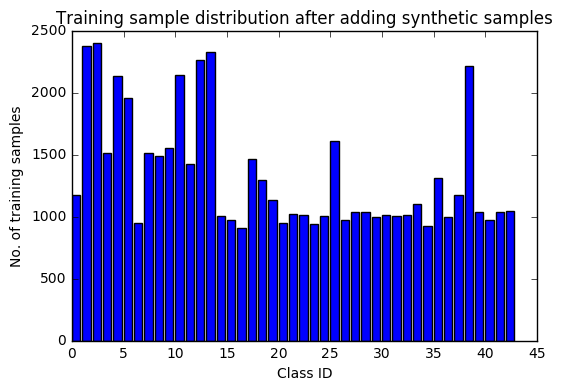

In [32]:
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])
plt.title("Training sample distribution after adding synthetic samples")
plt.xlabel("Class ID")
plt.ylabel("No. of training samples")

#### Shuffle training data

In [33]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [34]:
np.unique(y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64),
 array([1171, 2372, 2402, 1514, 2131, 1955,  947, 1510, 1491, 1549, 2145,
        1422, 2263, 2327, 1007,  969,  908, 1461, 1293, 1135,  949, 1021,
        1014,  942, 1006, 1612,  969, 1039, 1039,  998, 1014, 1006, 1009,
        1098,  921, 1310,  996, 1170, 2213, 1038,  975, 1039, 1047], dtype=int64))

### Model Architecture

In [35]:
tf.reset_default_graph()

In [36]:
KEEP_PROB = 0.7

In [37]:
n_color = X_train.shape[-1]

In [38]:
from tensorflow.contrib.layers import flatten

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return x

def relu(x):
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

# Weights Initializer
mu = 0
sigma = 0.1
    
w1 = tf.Variable(tf.random_normal([5, 5, n_color, 8], mean=mu, stddev=sigma, seed=SEED))
b1 = tf.Variable(tf.random_normal([8], mean=mu, stddev=sigma, seed=SEED))

w2 = tf.Variable(tf.random_normal([5, 5, 8, 20], mean=mu, stddev=sigma, seed=SEED))
b2 = tf.Variable(tf.random_normal([20], mean=mu, stddev=sigma, seed=SEED))

w3 = tf.Variable(tf.random_normal([500, 160], mean=mu, stddev=sigma, seed=SEED))
b3 = tf.Variable(tf.random_normal([160], mean=mu, stddev=sigma, seed=SEED))    

w4 = tf.Variable(tf.random_normal([160, 120], mean=mu, stddev=sigma, seed=SEED))
b4 = tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma, seed=SEED))

w5 = tf.Variable(tf.random_normal([120, n_classes], mean=mu, stddev=sigma, seed=SEED))
b5 = tf.Variable(tf.random_normal([n_classes], mean=mu, stddev=sigma, seed=SEED))

def LeNet(x, keep_prob=KEEP_PROB):
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x8.
    conv1 = conv2d(x, w1, b1, strides=1)
    
    # Activation.
    conv1 = relu(conv1)
    
    # dropout
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob, seed=SEED)

    # Pooling. Input = 28x28x8. Output = 14x14x8.
#     pool1 = avgpool2d(conv1, k=2)
    pool1 = maxpool2d(conv1, k=2)

    # Layer 2: Convolutional. Output = 10x10x20.
    conv2 = conv2d(pool1, w2, b2, strides=1)
    
    # Activation.
    conv2 = relu(conv2)
    
    # dropout
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob, seed=SEED)

    # Pooling. Input = 10x10x20. Output = 5x5x20.
#     pool2 = avgpool2d(conv2, k=2)
    pool2 = maxpool2d(conv2, k=2)
    
    # Flatten. Input = 5x5x20. Output = 500.
    flat = tf.reshape(pool2, [-1, 500])
    
    # Layer 3: Fully Connected. Input = 500. Output = 160.
    fully_connected_1 = tf.add(tf.matmul(flat, w3), b3)
    
    # Activation.
    fully_connected_1 = relu(fully_connected_1)
    
    # dropout
    fully_connected_1 = tf.nn.dropout(fully_connected_1, keep_prob=keep_prob, seed=SEED)
    
    # Layer 4: Fully Connected. Input = 160. Output = 120.
    fully_connected_2 = tf.add(tf.matmul(fully_connected_1, w4), b4)
    
    # Activation.
    fully_connected_2 = relu(fully_connected_2)
    
    # dropout
    fully_connected_2 = tf.nn.dropout(fully_connected_2, keep_prob=keep_prob, seed=SEED)

    # Layer 5: Fully Connected. Input = 120. Output = n_classes.
    logits = tf.add(tf.matmul(fully_connected_2, w5), b5)
    
    return logits

In [39]:
x = tf.placeholder(tf.float32, (None, 32, 32, n_color))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

##### Model evaluation

In [40]:
rate = 0.002

In [41]:
logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

# loss_operation = tf.reduce_mean(weighted_cross_entropy)
loss_operation = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [42]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,
                                                           keep_prob: KEEP_PROB})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

##### Train the model

In [43]:
EPOCHS = 50
BATCH_SIZE = 512

In [44]:
early_stopping = 10 # stop after n epochs without improvement
train_acc_list = []
validation_acc_list = []

In [45]:
model_name = './traffic_sign_classifier_{}_{}_{}_{}'.format(strftime("%Y%m%d_%H%M%S", gmtime()), BATCH_SIZE, rate, KEEP_PROB)

In [46]:
tf.set_random_seed(SEED)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        start = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
            
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        train_acc_list.append(train_accuracy)
        validation_acc_list.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Time taken = {:.1f}".format(time.time() - start))
        
        if validation_accuracy == max(validation_acc_list):
            saver.save(sess, model_name)
            print("Model saved, epoch:", i+1)
        
        if len(validation_acc_list) > early_stopping and (max(validation_acc_list[-early_stopping:]) < max(validation_acc_list)):
            print("Training accuracy hasn't improved for 5 epochs. Stopping..")
            break
        print()

Training...

EPOCH 1 ...
Train Accuracy = 0.511
Validation Accuracy = 0.502
Time taken = 74.1
Model saved, epoch: 1

EPOCH 2 ...
Train Accuracy = 0.697
Validation Accuracy = 0.671
Time taken = 72.1
Model saved, epoch: 2

EPOCH 3 ...
Train Accuracy = 0.775
Validation Accuracy = 0.731
Time taken = 73.2
Model saved, epoch: 3

EPOCH 4 ...
Train Accuracy = 0.815
Validation Accuracy = 0.776
Time taken = 74.4
Model saved, epoch: 4

EPOCH 5 ...
Train Accuracy = 0.849
Validation Accuracy = 0.798
Time taken = 71.6
Model saved, epoch: 5

EPOCH 6 ...
Train Accuracy = 0.868
Validation Accuracy = 0.810
Time taken = 72.1
Model saved, epoch: 6

EPOCH 7 ...
Train Accuracy = 0.886
Validation Accuracy = 0.839
Time taken = 72.2
Model saved, epoch: 7

EPOCH 8 ...
Train Accuracy = 0.902
Validation Accuracy = 0.851
Time taken = 72.3
Model saved, epoch: 8

EPOCH 9 ...
Train Accuracy = 0.912
Validation Accuracy = 0.860
Time taken = 69.8
Model saved, epoch: 9

EPOCH 10 ...
Train Accuracy = 0.917
Validation Accu

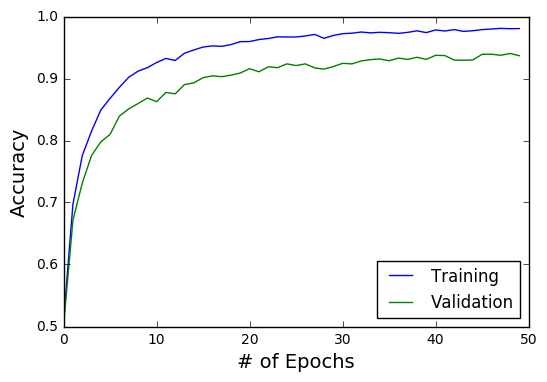

In [47]:
plt.plot(train_acc_list, label="Training")
plt.plot(validation_acc_list, label="Validation")
plt.legend(loc='lower right')
plt.xlabel("# of Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

#### PREDICTION

In [48]:
def predict(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    y_list = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        batch_y = sess.run(tf.argmax(logits, 1), feed_dict={x: batch_x, keep_prob: 1.})
        y_list.append(batch_y)
    return np.hstack(y_list)

def predict_prob(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    prob_list = []
    prob_ids_list = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        batch_prob, batch_prob_ids = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5),
                                              feed_dict={x: batch_x, keep_prob: 1.})
        prob_list.append(batch_prob)
        prob_ids_list.append(batch_prob_ids)
    return np.hstack(prob_list), np.hstack(prob_ids_list)

In [49]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

In [50]:
model_meta = tf.train.import_meta_graph("{}.meta".format(model_name))
with tf.Session() as sess:
    model_meta.restore(sess, tf.train.latest_checkpoint('.'))
    y_valid_pred = predict(X_valid)

INFO:tensorflow:Restoring parameters from .\traffic_sign_classifier_20191125_010558_512_0.002_0.7


In [51]:
classes = [str(i) for i in range(len(np.unique(y_valid)))]

Normalized confusion matrix
[[ 0.97  0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.95  0.03 ...,  0.    0.    0.  ]
 [ 0.    0.    1.   ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.02  0.   ...,  0.93  0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.7   0.  ]
 [ 0.    0.    0.   ...,  0.    0.    1.  ]]


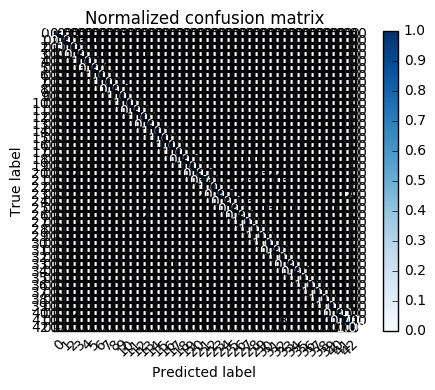

In [52]:
np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_valid, y_valid_pred, classes=classes,
#                       title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
cm_acc = plot_confusion_matrix(y_valid, y_valid_pred, classes=classes, normalize=True,
                               title='Normalized confusion matrix')

plt.show()

In [53]:
np.diagonal(cm_acc)

array([ 0.97,  0.95,  1.  ,  0.99,  1.  ,  0.94,  1.  ,  1.  ,  0.97,
        1.  ,  1.  ,  0.98,  1.  ,  0.99,  1.  ,  1.  ,  1.  ,  1.  ,
        0.97,  1.  ,  0.87,  0.7 ,  1.  ,  0.97,  0.97,  0.91,  0.98,
        1.  ,  1.  ,  1.  ,  1.  ,  0.99,  1.  ,  0.99,  0.95,  1.  ,
        1.  ,  1.  ,  1.  ,  1.  ,  0.93,  0.7 ,  1.  ])

In [54]:
c=0
for img, y_label in zip(X_valid[(y_valid_pred!=y_valid)], y_valid[(y_valid_pred!=y_valid)]):
    c+=1
    plt.imsave("debug_imgs/img_{}_label{}.png".format(c, y_label), img.squeeze(), cmap='gray')

In [55]:
# np.savetxt(X=cm_acc, delimiter=',', fname='cm.csv')

In [56]:
len(np.where(y_valid_pred==y_valid)[0])/len(y_valid)

0.9766439909297052

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [57]:
df_web_images = pd.read_csv("web_image_labels.csv")

In [58]:
X_web_test = np.array([cv2.resize(cv2.imread(img_i), (32,32)) for img_i in df_web_images['image_name'].tolist()])

In [59]:
if X_web_test.shape[-1]==3:
    X_web_test = X_web_test/255.
    X_web_test = rgb_to_gray(X_web_test)
else:
    print("Already converted to gray")

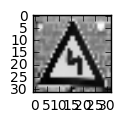

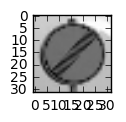

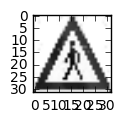

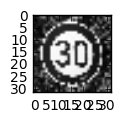

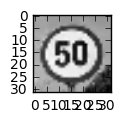

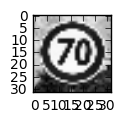

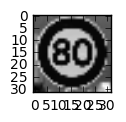

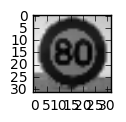

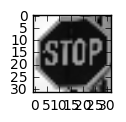

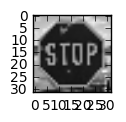

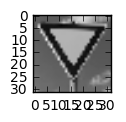

In [60]:
for img_ in X_web_test:
    plt.figure(figsize=(1,1))
    plt.imshow(img_.squeeze(), cmap='gray')

### Predict the Sign Type for Each Image

In [61]:
model_meta = tf.train.import_meta_graph("{}.meta".format(model_name))
with tf.Session() as sess:
    model_meta.restore(sess, tf.train.latest_checkpoint('.'))
#     y_web_pred = predict(X_web_test)
    y_web_pred = predict(X_web_test)
    y_pred_prob, y_pred_ids = predict_prob(X_web_test)
#     y_web_pred = y_pred_ids[:, 0]

INFO:tensorflow:Restoring parameters from .\traffic_sign_classifier_20191125_010558_512_0.002_0.7


In [62]:
df_web_images['predicted_label'] = y_web_pred
df_web_images['predicted_label_name'] = df_labels['SignName'].iloc[y_web_pred].values

In [63]:
df_web_images

,image_name,label_id,predicted_label,predicted_label_name
0,web_images_test/double_bend.png,21,21,Double curve
1,web_images_test/end_speed_limit.png,32,32,End of all speed and passing limits
2,web_images_test/pedestrian.jpg,27,27,Pedestrians
3,web_images_test/speed_limit_30.png,1,1,Speed limit (30km/h)
4,web_images_test/speed_limit_50.png,2,2,Speed limit (50km/h)
5,web_images_test/speed_limit_70.jpg,4,4,Speed limit (70km/h)
6,web_images_test/speed_limit_80.png,5,5,Speed limit (80km/h)
7,web_images_test/speed_limit_80_2.png,5,5,Speed limit (80km/h)
8,web_images_test/stop.png,14,14,Stop
9,web_images_test/stop_2.png,14,14,Stop


### Analyze Performance

In [64]:
## Calculate the accuracy for these test images from the web. 
web_images_acc = (df_web_images['label_id'] == df_web_images['predicted_label']).sum()/len(df_web_images)*100
print("Accuracy for test images from the web: {:.1f}%".format(web_images_acc))

Accuracy for test images from the web: 100.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [65]:
y_pred_prob, y_pred_ids

(array([[  1.00e+00,   3.38e-07,   8.39e-09,   8.27e-09,   3.59e-09],
        [  1.00e+00,   2.57e-05,   1.52e-06,   4.29e-09,   1.92e-09],
        [  1.00e+00,   2.54e-05,   7.01e-07,   3.61e-07,   4.73e-08],
        [  9.95e-01,   5.37e-03,   4.38e-07,   1.51e-09,   1.43e-09],
        [  1.00e+00,   7.82e-05,   1.45e-07,   5.98e-08,   6.93e-09],
        [  1.00e+00,   1.22e-04,   1.03e-04,   2.98e-05,   1.31e-05],
        [  1.00e+00,   8.29e-05,   7.17e-05,   2.00e-05,   1.91e-05],
        [  8.18e-01,   1.77e-01,   4.32e-03,   6.66e-05,   2.28e-06],
        [  1.00e+00,   1.17e-05,   2.73e-06,   9.61e-07,   7.48e-07],
        [  1.00e+00,   1.31e-04,   2.99e-05,   2.58e-05,   1.92e-05],
        [  1.00e+00,   4.10e-13,   9.48e-15,   1.09e-15,   6.79e-16]], dtype=float32),
 array([[21, 31, 25, 27, 11],
        [32,  6, 41,  1, 38],
        [27, 18, 24, 11, 26],
        [ 1,  2,  0,  5,  7],
        [ 2,  1,  3,  5,  7],
        [ 4,  1,  0, 40,  7],
        [ 5,  0,  3,  2,  1],
   

In [66]:
for i in range(len(y_pred_ids)):
    print("Actual Label: ", df_labels['SignName'].iloc[df_web_images['label_id'].iloc[i]])
    print("\t"+"\n\t".join(["{:.8f}: \t{}".format(y_pred_prob[i, j], 
                     df_labels['SignName'].iloc[y_pred_ids[i, j]]) for j in range(len(y_pred_ids[i]))]))

Actual Label:  Double curve
	0.99999964: 	Double curve
	0.00000034: 	Wild animals crossing
	0.00000001: 	Road work
	0.00000001: 	Pedestrians
	0.00000000: 	Right-of-way at the next intersection
Actual Label:  End of all speed and passing limits
	0.99997270: 	End of all speed and passing limits
	0.00002575: 	End of speed limit (80km/h)
	0.00000152: 	End of no passing
	0.00000000: 	Speed limit (30km/h)
	0.00000000: 	Keep right
Actual Label:  Pedestrians
	0.99997342: 	Pedestrians
	0.00002543: 	General caution
	0.00000070: 	Road narrows on the right
	0.00000036: 	Right-of-way at the next intersection
	0.00000005: 	Traffic signals
Actual Label:  Speed limit (30km/h)
	0.99462622: 	Speed limit (30km/h)
	0.00537328: 	Speed limit (50km/h)
	0.00000044: 	Speed limit (20km/h)
	0.00000000: 	Speed limit (80km/h)
	0.00000000: 	Speed limit (100km/h)
Actual Label:  Speed limit (50km/h)
	0.99992156: 	Speed limit (50km/h)
	0.00007817: 	Speed limit (30km/h)
	0.00000014: 	Speed limit (60km/h)
	0.00000006: 	

### Test Model on Test Images

In [67]:
model_meta = tf.train.import_meta_graph("{}.meta".format(model_name))
with tf.Session() as sess:
    model_meta.restore(sess, tf.train.latest_checkpoint('.'))
    y_test_pred = predict(X_test)

INFO:tensorflow:Restoring parameters from .\traffic_sign_classifier_20191125_010558_512_0.002_0.7


Normalized confusion matrix
[[ 0.93  0.05  0.   ...,  0.    0.    0.  ]
 [ 0.    0.99  0.   ...,  0.    0.    0.  ]
 [ 0.    0.01  0.98 ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.98  0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.9   0.  ]
 [ 0.    0.    0.   ...,  0.    0.02  0.98]]
Test images accuracy per class:  [ 0.93  0.99  0.98  0.95  0.97  0.91  0.99  0.89  0.97  0.99  0.98  0.92
  0.98  0.99  0.95  0.99  0.99  0.92  0.79  1.    0.98  0.8   0.88  0.95
  0.9   0.95  0.86  0.5   0.97  1.    0.69  0.99  1.    1.    0.99  0.95
  0.98  0.98  0.95  0.98  0.98  0.9   0.98]


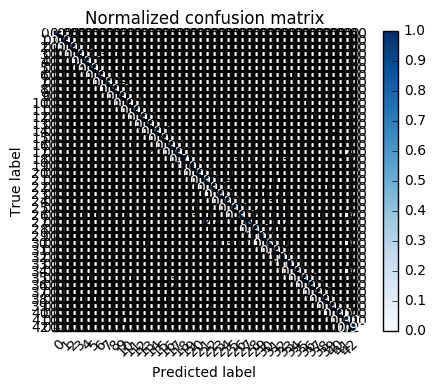

In [68]:
cm_acc_test = plot_confusion_matrix(y_test, y_test_pred, classes=classes, normalize=True,
                               title='Normalized confusion matrix')
print("Test images accuracy per class: ", np.diagonal(cm_acc_test))

In [69]:
test_acc = len(np.where(y_test_pred==y_test)[0])/len(y_test)
print("Overall Test Accuracy: {:.2f}".format(test_acc))

Overall Test Accuracy: 0.95


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [70]:
# ### Visualize your network's feature maps here.
# ### Feel free to use as many code cells as needed.

# # image_input: the test image being fed into the network to produce the feature maps
# # tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# # activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# # plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

# def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
#     # Here make sure to preprocess your image_input in a way your network expects
#     # with size, normalization, ect if needed
#     # image_input =
#     # Note: x should be the same name as your network's tensorflow data placeholder variable
#     # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
#     activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
#     featuremaps = activation.shape[3]
#     plt.figure(plt_num, figsize=(15,15))
#     for featuremap in range(featuremaps):
#         plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
#         plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
#         if activation_min != -1 & activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, vmax=activation_max, cmap="gray")
#         elif activation_max != -1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
#         elif activation_min !=-1:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
#         else:
#             plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")